In [1]:
import os
import numpy as np
import tomopy
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.prep.conversion as conv
import algotom.prep.calculation as calc
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [4]:
###################### need to change start
ipts="31148"
###################### need to change end

## Find CT scan location

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['December5_2022', 'December3_2022']

## Find OB location

In [6]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['December2_2022', 'December3_2022']

## Find DC location

In [7]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_12_05']

In [8]:
###################### need to change start
sample_name = "December3_2022"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "December3_2022")
dc_dir = os.path.join(dc_loc, "2022_12_05")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 643 of angle 180.04
Found index of 0 degree projections: 0 of angle 0.0
Loading 1288 CT projections...


1288it [00:18, 70.81it/s]


1288 CT projections loaded!
Shape: (1288, 2048, 2048)
Loading 10 Open Beam (OB) images...


10it [00:00, 81.77it/s]


10 Open Beam (OB) images loaded!
Shape: (10, 2048, 2048)
Loading 9 Dark Current (DC) images...


9it [00:00, 76.72it/s]

9 Dark Current (DC) images loaded!
Shape: (9, 2048, 2048)


# Visual verification of loaded files

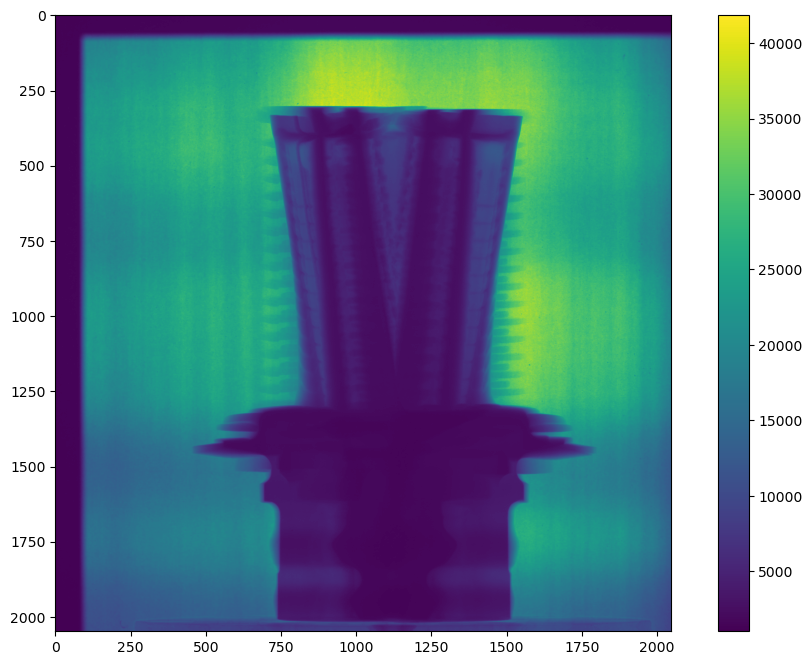

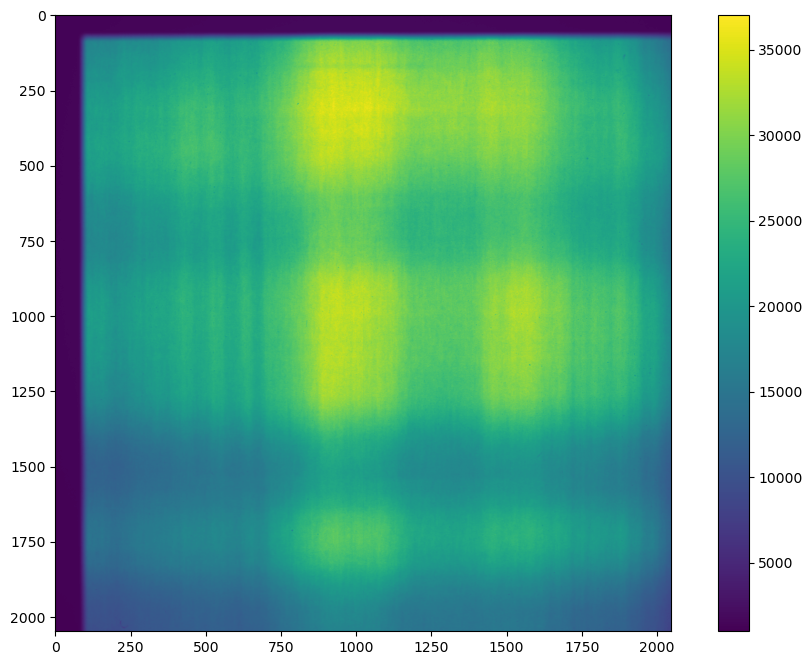

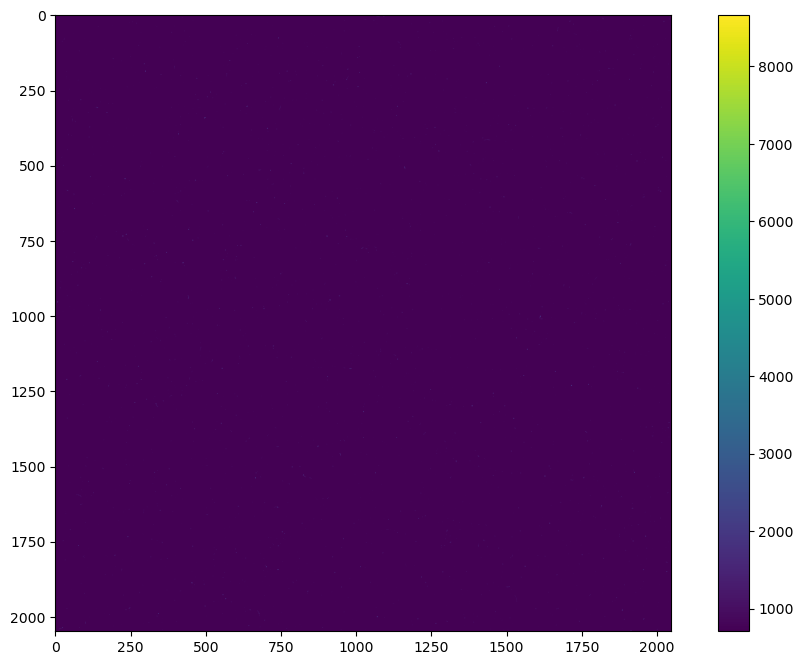

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


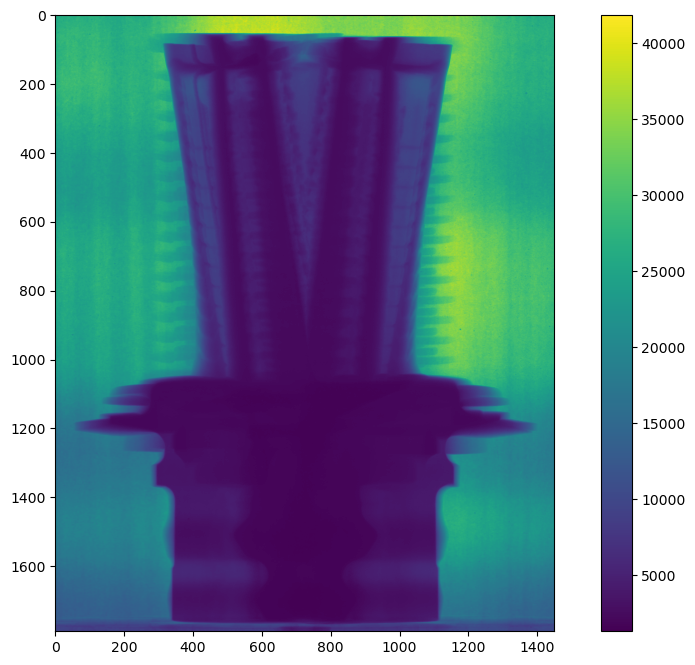

In [11]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 400
crop_right = 1850
crop_top = 250
crop_bottom = 2040
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)
history_dict = rocku.log(history_dict, 'gamma_diff', gamma_diff)

Time: 47.686181775061414 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(1288, 1790, 1450)


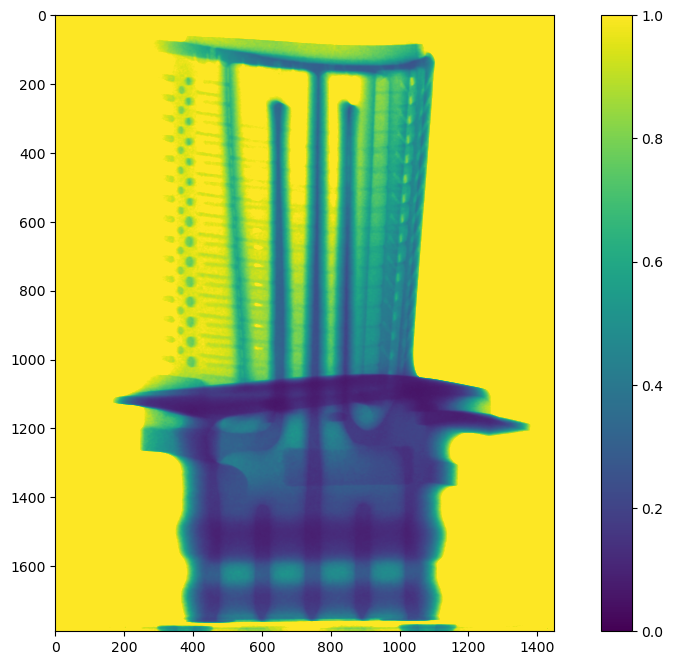

Time: 16.316695848014206 s


In [13]:
t0 = timeit.default_timer()
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Remove outliers again (optional)

t0 = timeit.default_timer()
proj_norm = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


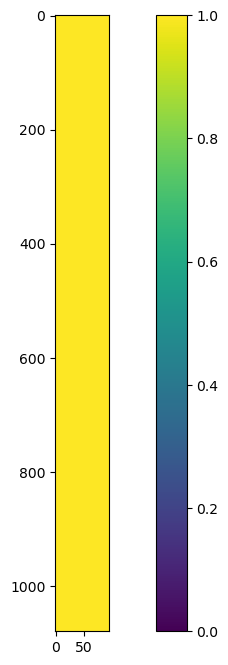

In [14]:
###################### need to change start
bg_left = 5
bg_right = 100
bg_top = 20
bg_bottom = 1100
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

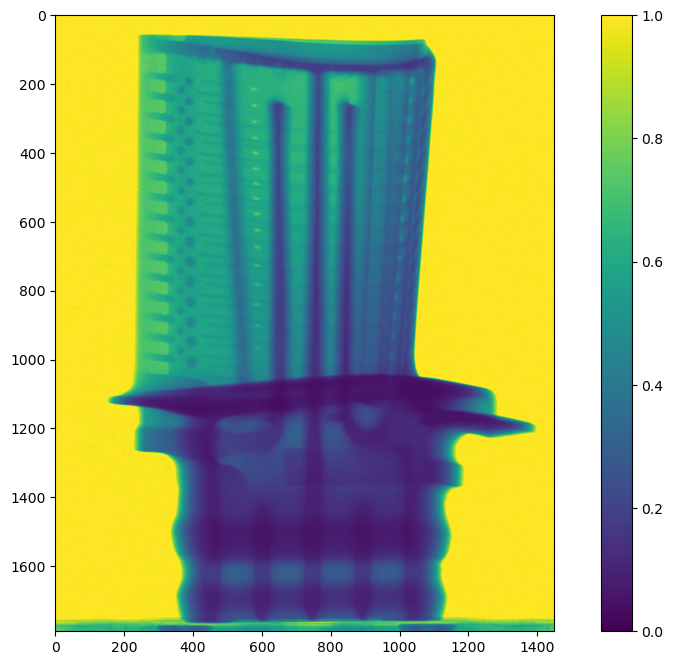

Time: 47.80592546798289 s


In [15]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

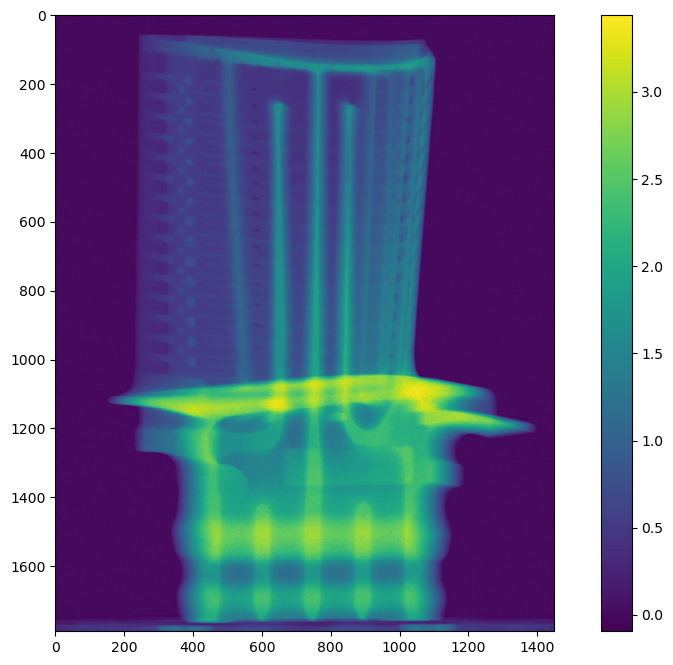

Time: 1.4790305239148438 s


In [16]:
t0 = timeit.default_timer()
_proj_norm = proj_norm[:]
proj_mlog = tomopy.minus_log(_proj_norm, ncore=ncore)
t1 = timeit.default_timer()
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)
print("Time: {} s".format(t1-t0))

# Remove outliers again (optional)

In [17]:
t0 = timeit.default_timer()
proj_mlog = tomopy.misc.corr.remove_outlier(proj_mlog, gamma_diff, ncore=ncore)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 19.852268473012373 s


# Find COR

In [18]:
# Covert to sinogram
sino_mlog = np.moveaxis(proj_mlog, 1, 0)
print("Finding the center of rotation (COR)...")
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center_360 = calc.find_center_360(sino_mlog[int(sino_mlog.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation (COR) with 360:', rot_center_360)
rot_center_180 = calc.find_center_vo(sino_mlog[int(sino_mlog.shape[0]/2)][:proj180_idx])
print('Estimated center of rotation (COR) with 180:', rot_center_180)
rot_center = rot_center_360

Finding the center of rotation (COR)...
Estimated center of rotation (COR) with 360: 726.6055421829224
Estimated center of rotation (COR) with 180: 727.25


# Check sinogram (if sample has moved during CT)

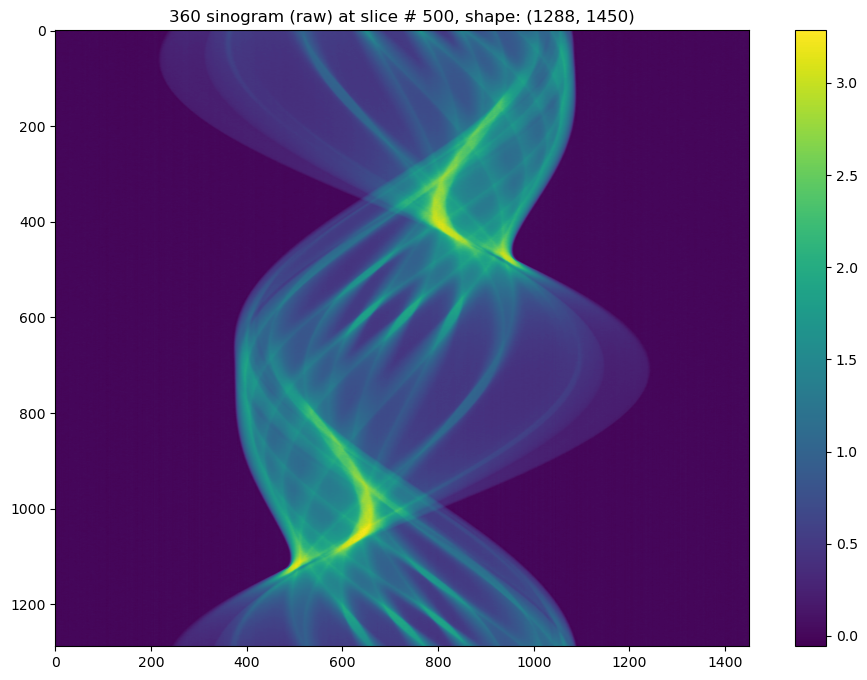

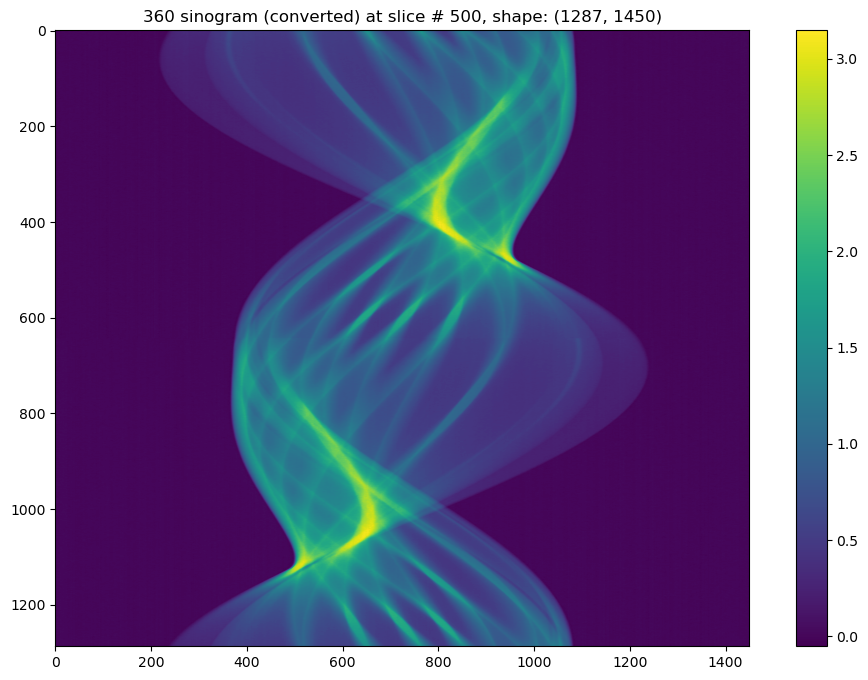

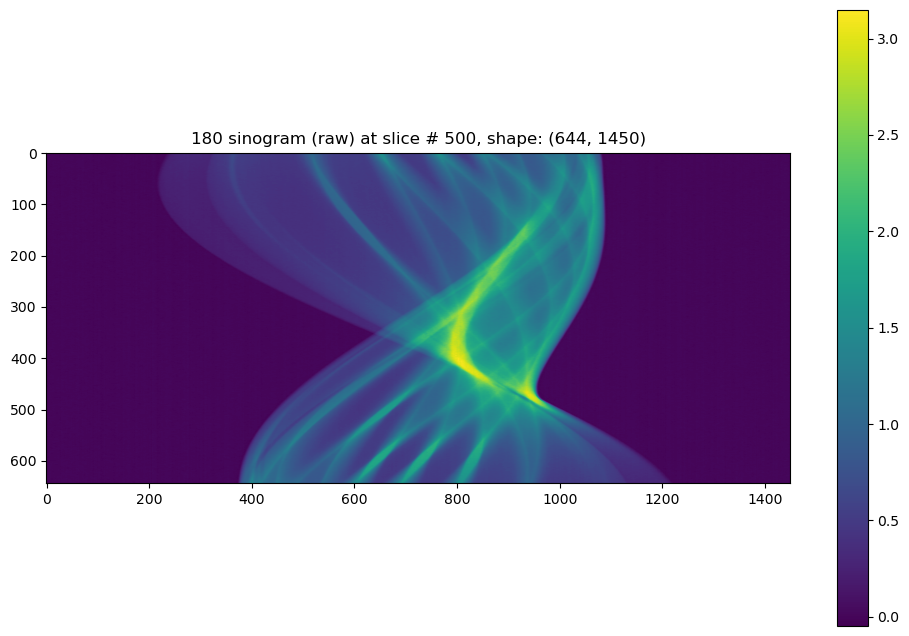

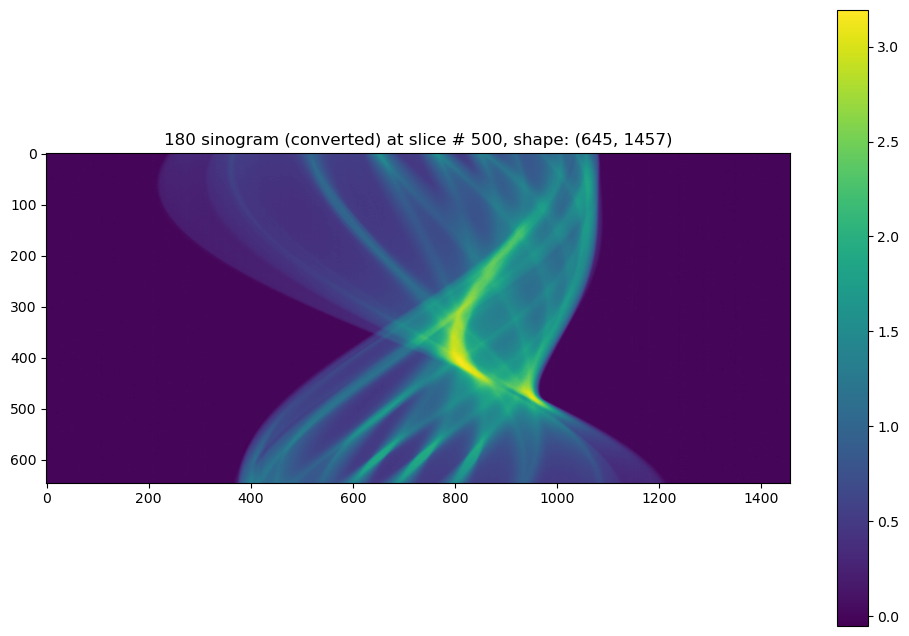

In [28]:
slice_num = 500
sino_360 = sino_mlog[slice_num]
sino_180 = sino_360[:proj180_idx+1]
sino_180_conv = conv.convert_sinogram_360_to_180(sino_360=sino_360, cor=rot_center_180)[0]
sino_360_conv = conv.convert_sinogram_180_to_360(sino_180=sino_180, center=rot_center_180)
plt.imshow(sino_360)
plt.title("360 sinogram (raw) at slice # {}, shape: {}".format(slice_num, sino_360.shape))
plt.colorbar()
plt.show()
plt.imshow(sino_360_conv)
plt.title("360 sinogram (converted) at slice # {}, shape: {}".format(slice_num, sino_360_conv.shape))
plt.colorbar()
plt.show()
plt.imshow(sino_180)
plt.title("180 sinogram (raw) at slice # {}, shape: {}".format(slice_num, sino_180.shape))
plt.colorbar()
plt.show()
plt.imshow(sino_180_conv)
plt.title("180 sinogram (converted) at slice # {}, shape: {}".format(slice_num, sino_180_conv.shape))
plt.colorbar()
plt.show()